# Exploratory analysis of univariate and compound events

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:05:00'
cores = 2
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.74.68:8787/status,
Dashboard: http://10.6.74.68:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.74.68:37799,Workers: 0
Dashboard: http://10.6.74.68:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [6]:
# %load_ext autoreload
# %autoreload 2

In [7]:
import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [8]:
import functions as fn

plt_params = fn.get_plot_params()

# Load masks

In [9]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

In [10]:
gccsa_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/gccsa_mask_era5_grid.nc'
).GCCSA

# Load energy source and demand data

In [11]:
years = range(1959, 2021)

Sources: daily wind, daily solar and monthly runoff

In [12]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w'].compute()

In [13]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd'].compute()

In [14]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro'].compute()

Demand: daily temperature

In [15]:
city_t = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/t2m_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_GCCSA_region_mean.zarr',
    consolidated=True
)['t2m'].compute()

# Convert to Celsius
city_t = city_t - 273.15

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021), or 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm)
- For hydro, use 20th percentile of annual total runoff by region (made up)

- For temperature demand, we use a lower limit of 15 C and an upper limit of 21 C. From here: https://www.energyrating.gov.au/sites/default/files/documents/Climate_zone_mapping_-_air_con_FINAL_title_updated_0.pdf

In [16]:
def get_events(da, thresh, tail='lower'):
    if tail == 'lower':
        return xr.where(da < thresh, 1, 0)
    elif tail == 'upper':
        return xr.where(da > thresh, 1, 0)
    else:
        raise ValueError('Incorrect string for tail')

In [17]:
def calculate_event_frequency(da, thresh,
                              tail, time_name='time'):
    T = len(da[time_name].values)
    events = get_events(da, thresh, tail)
    freq = events.sum(time_name) / T
            
    return freq

In [18]:
def freq_drought_compare(daily_events,
                         ann_da, thresh_ann_da,
                         tail='lower', time_name='time'):
    """
    Calculate frequency of daily events (i.e. days surpassing some threshold)
    on drought years (years below some threshold), and
    on all other years. Output is two dataarrays.
    
    daily_da: xarray dataarray of daily data
    thresh_daily_da: int, float or da. Threshold to define daily events.
    drought_da: xarray dataarray of annual data (typically runoff or precip)
    thresh_drought_da: int, float or da. Threshold to define drought events.
    tail: string, 'lower' (default) or 'upper'. Whether daily events are
        defined as below or above the threshold.
    """
    def freq_during_years(da, years, time_name):
        """
        Frequency of events on given years.
        """
        subset_da = da.sel(
            time=da[time_name].dt.year.isin(years)
        )
        counts = subset_da.sum(time_name)
        
        return counts / len(subset_da[time_name].values)
                                
    # We need to do it separately for each region because different times
    #  may be dropped (different drought years across regions).
    drought_da_list = []
    other_da_list = []
    for i, region in enumerate(daily_events.region.values):
        # Get drought and other years
        drought_years = ann_da.where(
            ann_da < thresh_ann_da
        ).sel(region=region).dropna('time').time.dt.year

        other_years = ann_da.where(
            ann_da >= thresh_ann_da
        ).sel(region=region).dropna('time').time.dt.year
        
        # Frequency during drought and other years
        r_events = daily_events.sel(region=region)
        
        freq_during_drought = freq_during_years(r_events,
                                                drought_years,
                                                time_name)
        freq_during_other = freq_during_years(r_events,
                                              other_years,
                                              time_name)
        
        drought_da_list.append(freq_during_drought)
        other_da_list.append(freq_during_other)
        
    drought_da = xr.concat(drought_da_list, dim='region')
    other_da = xr.concat(other_da_list, dim='region')
    
    return drought_da, other_da

In [19]:
def get_regions_from_region_codes(region_codes):
    regions = [rez_mask.region.values[i] for i in range(len(rez_mask.region.values)) if
               rez_mask.region_code.values[i] in region_codes]
    return regions

In [56]:
def plot_freq(ax, da, title, mask, region_codes=None, vmin_vmax_interval='auto'):

    regions = da.region
    if isinstance(region_codes, list):
        regions = get_regions_from_region_codes(region_codes)
    da = xr.where(mask.sel(region=regions),
                  da.sel(region=regions),
                  np.nan)
    da = da.sum('region', skipna=True)
    plot_da = da.where(mask.sel(region=regions).sum('region'))
    
    # Get data and colorbar limits
    if vmin_vmax_interval == 'auto':
        da_max = plot_da.max().values
        da_min = plot_da.min().values
        
        if da_min >= 0: # For positive data, this will lie 0-1
            cmap = 'viridis'
            vmin = 0
            if da_max > 0.2:
                vmax = fn.round_decimals_up(da_max, 1)
                cbar_tick_intervals = 0.1
            elif da_max > 0.05:
                vmax = fn.round_decimals_up(da_max, 2)
                cbar_tick_intervals = 0.01
            else:
                vmax = fn.round_decimals_up(da_max, 3)
                cbar_tick_intervals = 0.001
        else: # Symmetric data
            cmap = 'RdBu_r'
            abs_max = np.max([np.abs(da_min), da_max])
            if abs_max > 0.2:
                vmax = fn.round_decimals_up(abs_max, 1)
                cbar_tick_intervals = 0.1
            elif abs_max > 0.1:
                vmax = fn.round_decimals_up(abs_max, 2)
                cbar_tick_intervals = 0.01
            else:
                vmax = fn.round_decimals_up(abs_max, 2)
                cbar_tick_intervals = 0.01
            vmin = -vmax
                
    elif isinstance(vmin_vmax_interval, list):
        cmap = 'viridis'
        vmin = vmin_vmax_interval[0]
        vmax = vmin_vmax_interval[1]
        cbar_tick_intervals = vmin_vmax_interval[2]
    else:
        raise ValueError("vmin_vmax_interval should be 'auto' or list with the \
        first element the desired vmin, and the second element vmax.")
                
    with plt.rc_context(plt_params):
        ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=plt_params['lines.linewidth'] / 3
        )

        plot_da.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax,
                    cbar_kwargs={
                        'orientation': 'vertical',
                        'ticks': np.arange(vmin, vmax+cbar_tick_intervals, cbar_tick_intervals),
                        'label': 'Relative frequency [-]'
                    })
        # ax.text(0.06, 0.05, title,
        #         bbox=dict(facecolor='white', edgecolor='k', lw=0.5, alpha=1), transform=ax.transAxes)
        ax.set_title(title)

In [21]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

In [22]:
thresh_100w = 4
thresh_mssrd = 170
thresh_ro = rez_ro_ann.quantile(0.2, 'time')
thresh_t_cool = 15
thresh_t_warm = 21

### Frequencies of univariate events

In [23]:
freq_100w = calculate_event_frequency(rez_100w, thresh_100w, tail='lower')

In [24]:
freq_mssrd = calculate_event_frequency(rez_mssrd, thresh_mssrd, tail='lower')

In [25]:
freq_ro = calculate_event_frequency(rez_ro_ann, thresh_ro, tail='lower')

In [26]:
freq_t_upp = calculate_event_frequency(city_t, thresh_t_warm, tail='upper')

In [27]:
freq_t_low = calculate_event_frequency(city_t, thresh_t_cool, tail='lower')

### Frequencies of compound wind and solar lulls

In [28]:
freq_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
).sum('time') / len(rez_100w.time.values)

### Solar and/or wind lulls compounding with hydropower droughts

We show the difference in relative frequency between wind/solar/compound lulls on drought years and all other years (drought - other).

Only REZs with hydro are shown, because the drought years are specific to each REZ.

Wind during drought

In [29]:
events_100w = get_events(rez_100w, thresh_100w, tail='lower')

freq_drought_100w, freq_other_100w = freq_drought_compare(
    events_100w, rez_ro_ann, thresh_ro, tail='lower'
)

Solar during drought

In [30]:
events_mssrd = get_events(rez_mssrd, thresh_mssrd, tail='lower')

freq_drought_mssrd, freq_other_mssrd = freq_drought_compare(
    events_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

Wind and solar during drought

In [31]:
events_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
)

freq_drought_100w_mssrd, freq_other_100w_mssrd = freq_drought_compare(
    events_100w_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

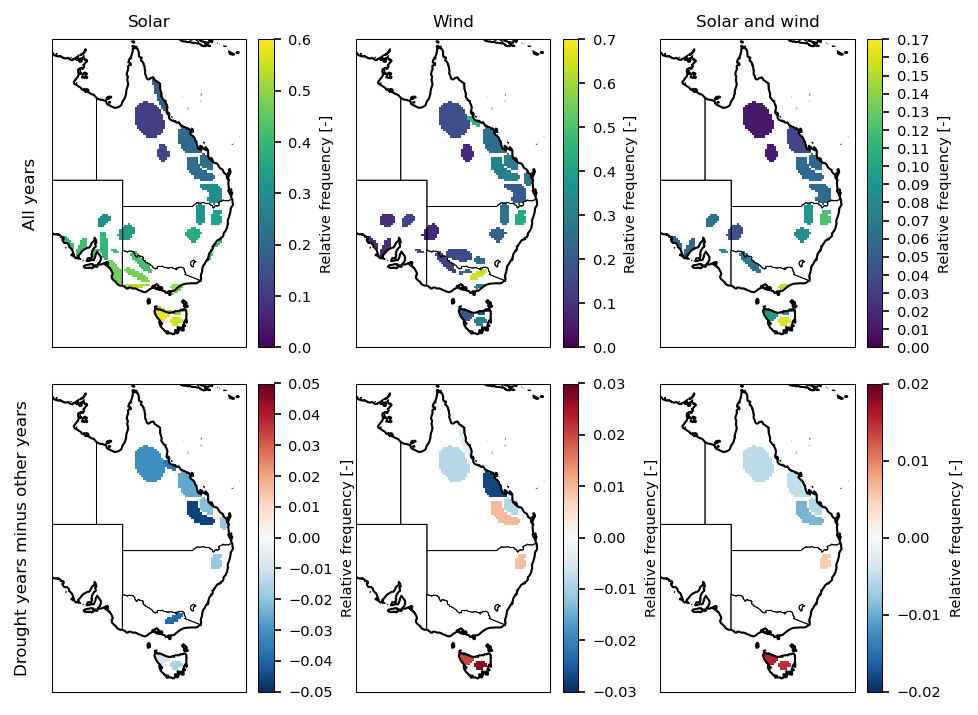

In [63]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=150)

    ax1 = plt.subplot(231, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(232, projection=ccrs.PlateCarree())
    ax3 = plt.subplot(233, projection=ccrs.PlateCarree())
    ax4 = plt.subplot(234, projection=ccrs.PlateCarree())
    ax5 = plt.subplot(235, projection=ccrs.PlateCarree())
    ax6 = plt.subplot(236, projection=ccrs.PlateCarree())
    
    plot_freq(ax1, freq_mssrd, 'Solar', mask=rez_mask, region_codes=[1, 3, 5, 7])
    plot_freq(ax2, freq_100w, 'Wind', mask=rez_mask, region_codes=[2, 3, 6, 7])
    plot_freq(ax3, freq_100w_mssrd, 'Solar and wind', mask=rez_mask, region_codes=[3, 7])
    plot_freq(ax4, freq_drought_mssrd - freq_other_mssrd,
              '', mask=rez_mask, region_codes=[6, 7])
    plot_freq(ax5, freq_drought_100w - freq_other_100w,
              '', mask=rez_mask, region_codes=[5, 7])
    plot_freq(ax6, freq_drought_100w_mssrd - freq_other_100w_mssrd,
              '', mask=rez_mask, region_codes=[7])
    
    ax1.text(-0.15, 0.5, 'All years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax1.transAxes, va='center')
    ax4.text(-0.15, 0.5, 'Drought years minus other years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax4.transAxes, va='center', ha='center')
    
    plt.tight_layout()

# How often do these lulls occur simultaneously across regions?

In [53]:
events_100w = get_events(rez_100w, thresh_100w)

In [54]:
events_mssrd = get_events(rez_mssrd, thresh_mssrd)

### Avg number of regions per year experiencing lulls

#### Annual means

In [55]:
annual_w100 = events_100w.sum('region').resample(time='1YS').mean()
annual_mssrd = events_mssrd.sum('region').resample(time='1YS').mean()

annual_both = events_100w + events_mssrd
annual_both = xr.where(annual_both == 2, 1, 0).sum('region').resample(time='1YS').mean()

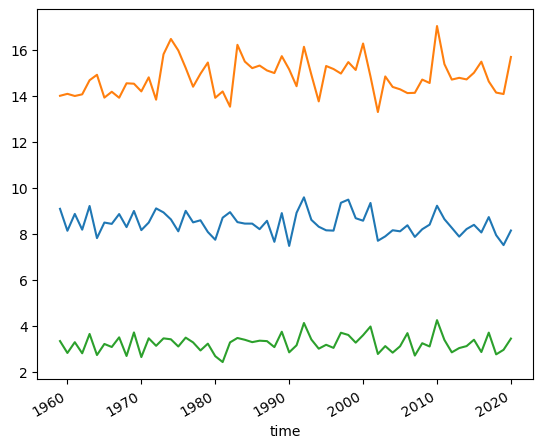

In [40]:
fig, ax = plt.subplots(1, 1)
annual_w100.plot(ax=ax)
annual_mssrd.plot(ax=ax)
annual_both.plot(ax=ax)

#### Warm/cool season means

In [56]:
m6_w100 = events_100w.sum('region').resample(time='1MS').mean().rolling(time=6).mean()
warm_w100 = m6_w100.isel(time=m6_w100.time.dt.month == 3)
cool_w100 = m6_w100.isel(time=m6_w100.time.dt.month == 9)

m6_mssrd = events_mssrd.sum('region').resample(time='1MS').mean().rolling(time=6).mean()
warm_mssrd = m6_mssrd.isel(time=m6_mssrd.time.dt.month == 3)
cool_mssrd = m6_mssrd.isel(time=m6_mssrd.time.dt.month == 9)

m6_both = events_100w + events_mssrd
m6_both = xr.where(m6_both == 2, 1, 0).sum('region').resample(time='1MS').mean().rolling(time=6).mean()
warm_both = m6_both.isel(time=m6_both.time.dt.month == 3)
cool_both = m6_both.isel(time=m6_both.time.dt.month == 9)

In [51]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

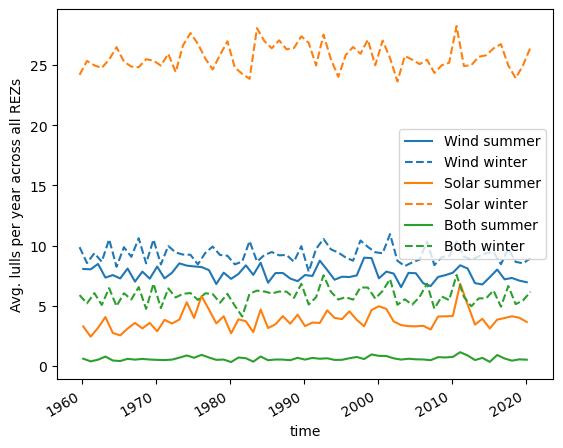

In [55]:
fig, ax = plt.subplots(1, 1)

warm_w100.plot(ax=ax, c=colors[0], label='Wind summer')
cool_w100.plot(ax=ax, c=colors[0], ls='--', label='Wind winter')

warm_mssrd.plot(ax=ax, c=colors[1], label='Solar summer')
cool_mssrd.plot(ax=ax, c=colors[1], ls='--', label='Solar winter')

warm_both.plot(ax=ax, c=colors[2], label='Both summer')
cool_both.plot(ax=ax, c=colors[2], ls='--', label='Both winter')

ax.set_ylabel('Avg. lulls per year across all REZs')
ax.legend()

# Daily events plot

In [63]:
def to_dayofyear(ds):
    """
    Reshapes array from time to year and dayofyear. Leap year days are manually
    removed, and days after this are reassigned as if there was no leap year.
    So dayofyear is always 1-365.
    
    From: https://github.com/pydata/xarray/discussions/5119#discussioncomment-581232
    """
    from itertools import cycle
    
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(
        year=("time", year.data),
        dayofyear=("time", day.data)
    )

    # reshape the array to (..., "month", "year")
    return ds.set_index(
        time=("year", "dayofyear")
    ).unstack("time") 

Remove leap year days (29/02) so we have equal row lengths

In [65]:
w100_2d = to_dayofyear(events_100w.convert_calendar('noleap'))
mssrd_2d = to_dayofyear(events_mssrd.convert_calendar('noleap'))

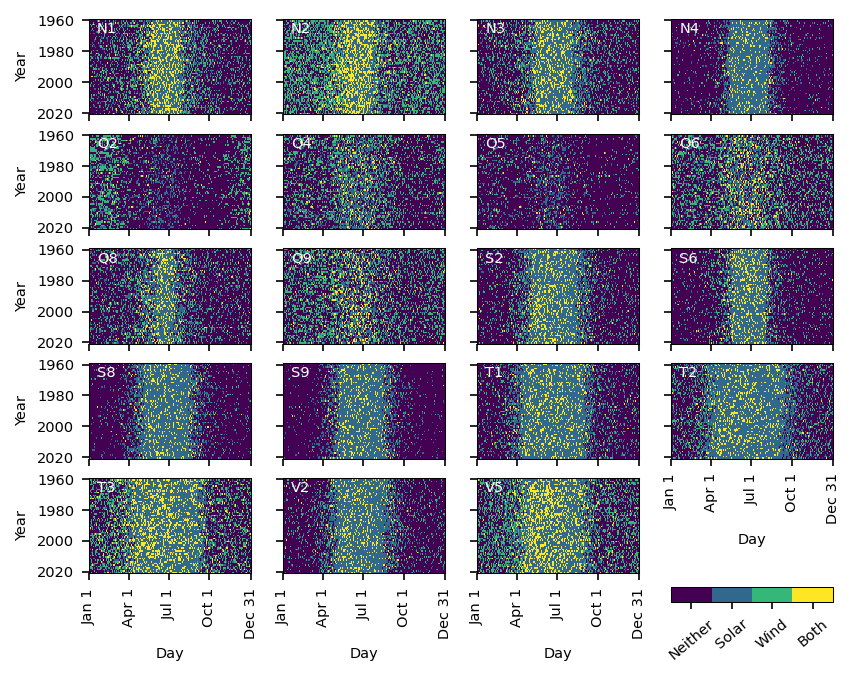

In [66]:
regions = get_regions_from_region_codes([3, 7])
d = mssrd_2d + w100_2d * 2

cmap = matplotlib.cm.get_cmap('viridis')
cmapBig = matplotlib.cm.get_cmap('viridis', 512)
cmap_max = 512
cbar_max = 4.5
newcmap = matplotlib.colors.ListedColormap(cmapBig(np.linspace(0, 1, cmap_max//2)))
norm = matplotlib.colors.BoundaryNorm(np.arange(cbar_max + 0.5), newcmap.N)

with plt.rc_context(plt_params):
    fig, ax = plt.subplots(5, 4, dpi=150)
    
    for i, region in enumerate(regions):
        # d.sel(region=region).plot(ax=ax.flatten()[i],
        #                           add_colorbar=False)
        p = ax.flatten()[i].pcolormesh(
            d.sel(region=region).data,
            cmap=cmap, norm=norm
        )
        ax.flatten()[i].set_ylim(ax.flatten()[i].get_ylim()[::-1])
        
        ax.flatten()[i].set_title('')
        ax.flatten()[i].text(0.05, 0.85, region,
                             c='w', transform=ax.flatten()[i].transAxes)
        
        if i in [0, 4, 8, 12, 16]:
            ax.flatten()[i].set_ylabel('Year')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels(range(1960, 2021, 20))
        else:
            ax.flatten()[i].set_ylabel('')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels('')
            
        if i > 14:
            ax.flatten()[i].set_xlabel('Day')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels(['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1', 'Dec 31'],
                                           rotation=90)
        else:
            ax.flatten()[i].set_xlabel('')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels('')
            
    ax.flatten()[-1].axis('off')
    
    axins1 = inset_axes(ax.flatten()[-1], width="200%", height="20%",
                        bbox_to_anchor=(.5, -0.3, .5, .8),
                        bbox_transform=ax.flatten()[-1].transAxes, loc='lower right', borderpad=0)
    cb1 = fig.colorbar(p, cax=axins1, orientation='horizontal', ticks=np.arange(0.5, cbar_max, 1))
    cb1.ax.minorticks_off()
    cb1.ax.set_xticklabels(['Neither', 'Solar', 'Wind', 'Both'], rotation=40)

# Close cluster

In [52]:
client.close()
cluster.close()